# Análise de dados dos chamados 1746 com geolocalização

Esse notebook apresenta as respostas para as perguntas do arquivo `perguntas_desafio.md` relacionados a localização dos chamados 1746.

O dataset utilizado para a análise é gerado pelo arquivo `01_generate_dataset_localizacao_chamados.py`. Nele estão contidos dados referentes a abril de 2023. Cada linha corresponde a um chamado com informações da localização, qual seu tipo e subtipo, data de inicio e fim do chamado, além de informações do bairro do chamado. As tabelas utilizadas para obter essas informações são: `datario.dados_mestres.bairro` e `datario.administracao_servicos_publicos.chamado_1746`.

# 1. Imports

In [1]:
import pandas as pd
from datetime import date

# 2. Read dataset

In [2]:
df = pd.read_parquet(
    "../datasets/raw/dataset_chamado_1746_with_geoloc_2023-04-01.parquet.gzip"
)
print("dataset shape: ", df.shape)
df.head()

dataset shape:  (65938, 37)


,id_chamado,data_inicio,data_fim,id_bairro,id_territorialidade,id_logradouro,numero_logradouro,id_unidade_organizacional,nome_unidade_organizacional,id_unidade_organizacional_mae,...,tipo_situacao,justificativa_status,reclamacoes,data_particao,geometry,nome_bairro,subprefeitura_bairro,area_bairro,perimetro_bairro,geometry_bairro
0,18572008,2023-04-15 14:29:06,2023-04-15 20:49:39,138,5,37176,<NA>,24,GMA - Gerência de Manutenção Semafórica,CET-RIO - Companhia de Engenharia de Tráfego d...,...,Atendido,None,0,2023-04-01,None,Magalhães Bastos,Grande Bangu,1.975949e+06,6902.663944,"POLYGON((-43.4092888518653 -22.882692479969, -..."
1,18555003,2023-04-11 21:20:11,2023-04-11 22:44:59,144,5,13169,<NA>,24,GMA - Gerência de Manutenção Semafórica,CET-RIO - Companhia de Engenharia de Tráfego d...,...,Não constatado,None,0,2023-04-01,None,Campo Grande,Zona Oeste,1.044451e+08,75083.751962,"POLYGON((-43.5151513986435 -22.8522866123935, ..."
2,18524112,2023-04-03 16:04:34,2023-04-03 17:10:47,151,5,136010,206,24,GMA - Gerência de Manutenção Semafórica,CET-RIO - Companhia de Engenharia de Tráfego d...,...,Não constatado,None,0,2023-04-01,None,Guaratiba,Zona Oeste,1.317866e+08,88693.995709,MULTIPOLYGON(((-43.6606289230523 -22.999450064...
3,18546611,2023-04-10 12:47:06,2023-04-10 20:52:37,141,5,17228,<NA>,24,GMA - Gerência de Manutenção Semafórica,CET-RIO - Companhia de Engenharia de Tráfego d...,...,Não atendido,None,0,2023-04-01,None,Bangu,Grande Bangu,3.596620e+07,46529.035222,"POLYGON((-43.4871729943856 -22.8488053266659, ..."
4,18523976,2023-04-03 15:44:19,2023-04-04 11:31:43,151,5,136010,206,19,CTRT/AP 5.3 - Coordenadoria Técnica Regional d...,CET-RIO - Companhia de Engenharia de Tráfego d...,...,Não constatado,None,0,2023-04-01,None,Guaratiba,Zona Oeste,1.317866e+08,88693.995709,MULTIPOLYGON(((-43.6606289230523 -22.999450064...


A seguir, vamos fazer algumas validações a respeito:
- Tipos dos dados
- Quantidade de valores nulos
- Se existe dados duplicados

In [3]:
## Visualizando dtypes
df.dtypes

id_chamado                                  object
data_inicio                         datetime64[ns]
data_fim                            datetime64[ns]
id_bairro                                   object
id_territorialidade                         object
id_logradouro                               object
numero_logradouro                            Int64
id_unidade_organizacional                   object
nome_unidade_organizacional                 object
id_unidade_organizacional_mae               object
unidade_organizacional_ouvidoria            object
categoria                                   object
id_tipo                                     object
tipo                                        object
id_subtipo                                  object
subtipo                                     object
status                                      object
longitude                                  float64
latitude                                   float64
data_alvo_finalizacao          

Os dados estão com seus tipos corretos e iguais ao visto no BigQuery.

É importante que os id_chamados sejam únicos pois isso garante que cada linha se refira a um único chamado. Para garantir que está tudo correto, vamos verificar se temos ids duplicados

In [4]:
df[df.duplicated(subset=["id_chamado"])]

,id_chamado,data_inicio,data_fim,id_bairro,id_territorialidade,id_logradouro,numero_logradouro,id_unidade_organizacional,nome_unidade_organizacional,id_unidade_organizacional_mae,...,tipo_situacao,justificativa_status,reclamacoes,data_particao,geometry,nome_bairro,subprefeitura_bairro,area_bairro,perimetro_bairro,geometry_bairro


Agora vamos avaliar a quantidade de dados nulos. É importante que não exista id_chamados nulos e também que cada um seja associado a uma data_inicio pois assim evitamos perdas de registros.

In [5]:
# Verificando valores nulos
(df.isnull().sum() / df.shape[0]) * 100.0

id_chamado                            0.000000
data_inicio                           0.000000
data_fim                             30.630289
id_bairro                             3.861203
id_territorialidade                   3.861203
id_logradouro                         3.861203
numero_logradouro                    11.806546
id_unidade_organizacional             0.000000
nome_unidade_organizacional           0.000000
id_unidade_organizacional_mae         0.000000
unidade_organizacional_ouvidoria      0.000000
categoria                             0.000000
id_tipo                               0.000000
tipo                                  0.000000
id_subtipo                            0.000000
subtipo                               0.000000
status                                0.000000
longitude                            34.265522
latitude                             34.265522
data_alvo_finalizacao                 3.529073
data_alvo_diagnostico                95.738421
data_real_dia

Por fim, vamos avaliar que os dados contidos nesse dataset contém apenas dados de 04/2023.

In [6]:
df_div_monthyear = df[["data_inicio", "data_particao"]].copy()
df_div_monthyear["data_inicio_month"] = df_div_monthyear["data_inicio"].dt.month
df_div_monthyear["data_inicio_year"] = df_div_monthyear["data_inicio"].dt.year
df_div_monthyear.groupby("data_particao")[
    ["data_inicio_month", "data_inicio_year"]
].value_counts()

data_particao  data_inicio_month  data_inicio_year
2023-04-01     4                  2023                65938
dtype: int64

Os dados estão com ótima qualidade! Não existe id_chamado duplicados e nulos (estão consistentes), os tipos de dados estão corretos e conforme tabela com BigQuery e também cada chamado tem sua data_inicio definida com todos os dados sendo de abril de 2023!

# 3. Respondendo perguntas

Com os dados validados, agora vamos responder as perguntas!

## 1. Quantos chamados foram abertos no dia 01/04/2023?


In [7]:
df_apr = df[df["data_inicio"].dt.date == date(2023, 4, 1)]
print("Quantidade de chamados em 01/04/2023: ", df_apr.shape[0])

Quantidade de chamados em 01/04/2023:  73


## 2. Qual o tipo de chamado que teve mais teve chamados abertos no dia 01/04/2023?


Poluição sonora             24
Estacionamento Irregular     9
Iluminação Pública           8
Remoção Gratuita             5
Limpeza                      5
Postura Municipal            4
Pavimentação                 3
Ocupação de área pública     3
Manejo Arbóreo               2
Comlurb - Vetores            2
Fiscalização de obras        2
Semáforo                     1
Comércio ambulante           1
Ônibus                       1
Drenagem e Saneamento        1
Programa Cegonha Carioca     1
Feiras                       1
Name: tipo, dtype: int64

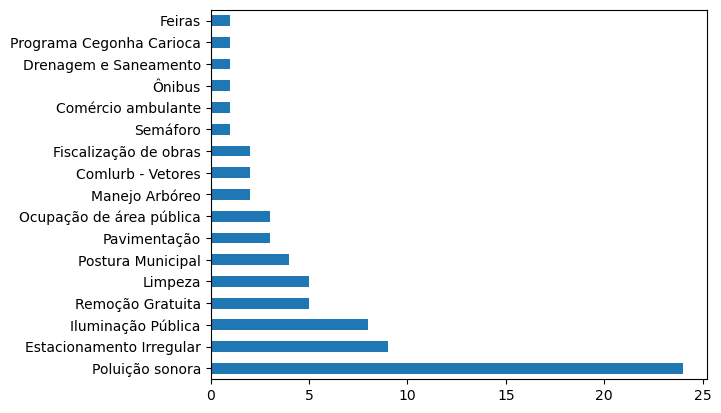

In [8]:
df_apr["tipo"].value_counts().plot.barh()
df_apr["tipo"].value_counts()

Conforme ilustra os dados acima, poluição sonora foi o que mais apresentou chamados em 01/04/2023 seguido de estacionamento irregular e iluminação pública.

## 3. Quais os nomes dos 3 bairros que mais tiveram chamados abertos nesse dia?


Engenho de Dentro    8
Leblon               6
Campo Grande         6
Engenho da Rainha    5
Barra da Tijuca      5
Tijuca               3
Santa Teresa         3
Bangu                2
Irajá                2
Ipanema              2
Name: nome_bairro, dtype: int64

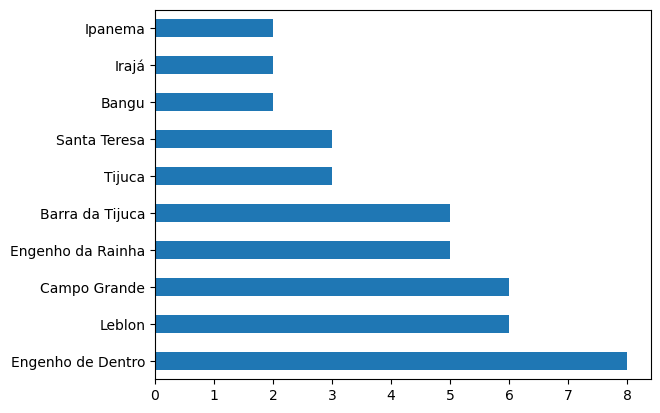

In [9]:
df_apr["nome_bairro"].value_counts(ascending=False)[:10].plot.barh()
df_apr["nome_bairro"].value_counts(ascending=False)[:10]

Engenho de Dentro, Lebon e Campo Grande de acordo com os dados são os bairros com mais chamados abertos em 01/04/2023

## 4. Qual o nome da subprefeitura com mais chamados abertos nesse dia?


Zona Norte         25
Zona Sul           12
Zona Oeste         10
Centro              7
Barra da Tijuca     6
Jacarepaguá         5
Grande Tijuca       4
Grande Bangu        3
Name: subprefeitura_bairro, dtype: int64

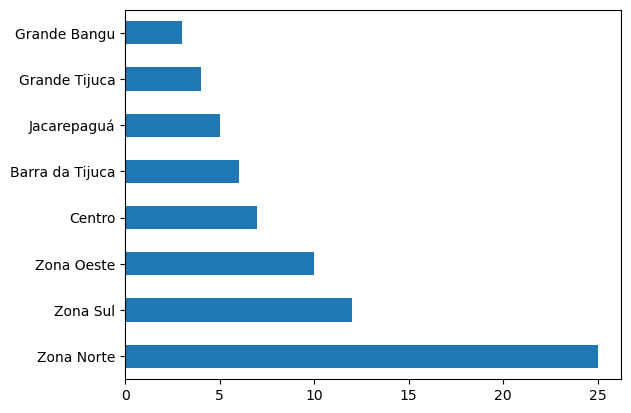

In [10]:
df_apr["subprefeitura_bairro"].value_counts(ascending=False).plot.barh()
df_apr["subprefeitura_bairro"].value_counts()

A subprefeitura da Zona Norte foi que a mais teves chamados abertos em 01/04/2023

## 5. Existe algum chamado aberto nesse dia que não foi associado a um bairro ou subprefeitura na tabela de bairros? Se sim, por que isso acontece?


Sim, existe um registro que não está associado a um id_bairro, por causa disso, ele não tem informações de bairro e subprefeitura.

In [11]:
df_apr[["id_bairro", "nome_bairro", "subprefeitura_bairro"]].isna().sum()

id_bairro               1
nome_bairro             1
subprefeitura_bairro    1
dtype: int64

In [12]:
df_apr[
    (df_apr["id_bairro"].isnull())
    | (df_apr["nome_bairro"].isnull())
    | (df_apr["subprefeitura_bairro"].isnull())
]

,id_chamado,data_inicio,data_fim,id_bairro,id_territorialidade,id_logradouro,numero_logradouro,id_unidade_organizacional,nome_unidade_organizacional,id_unidade_organizacional_mae,...,tipo_situacao,justificativa_status,reclamacoes,data_particao,geometry,nome_bairro,subprefeitura_bairro,area_bairro,perimetro_bairro,geometry_bairro
323,18516246,2023-04-01 00:55:38,2023-04-01 00:55:38,None,None,None,<NA>,1706,TR/SUBOP/CFT - Coordenadoria de Fiscalização e...,SMTR - Secretaria Municipal de Transportes,...,Atendido parcialmente,None,0,2023-04-01,None,None,None,NaN,NaN,None
